In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from fbprophet import Prophet

In [22]:
class ProphetForecaster():
    
    def __init__(self):
        self.model = None
        self.regressors = []
        self.seasonalities = None
        
    def add_seasonalities(self, seasonalities):
        self.seasonalities = seasonalities
        
    def apply_seasonalities(self, model):
        for i in self.seasonalities:
            model.add_seasonality(**i)
            
    def apply_regressors(self, model):
        for i in self.regressors:
            model.add_regressor(i)
    
    def add_train_data(self, df):
        self.train_data = df
    
    def add_regressor(self, regr_df, regr_name, freq='30min'):
        self.regressors.append(regr_name)
        df = regr_df.copy()
        df = df.sort_values(by=['ds'])
        df['ds'] = pd.to_datetime(df['ds'])
        hours = pd.Timedelta(hours=12)
        cut_tdf = df [df['ds'] >= self.train_data['ds'].values[0] - hours]
        cut_tdf = cut_tdf [cut_tdf['ds'] <= self.train_data['ds'].values[-1]]
        cut_tdf = cut_tdf.set_index('ds')
        cut_tdf = cut_tdf.reindex(pd.date_range(start=cut_tdf.index.min(),
                                                  end=cut_tdf.index.max(),
                                                  freq=freq))
        cut_tdf = cut_tdf.interpolate(method='linear')
        cut_tdf = cut_tdf [cut_tdf.index.values >= self.train_data['ds'].values[0]]
        
        a = pd.Series(self.train_data['ds'].values)
        b = pd.Series(cut_tdf.index.values)
        drop_indexes = pd.concat([a,b]).drop_duplicates(keep=False)
        self.train_data = self.train_data.drop(drop_indexes.index.values).reset_index(drop=True)
        self.train_data[regr_name] = cut_tdf[regr_name].values
        
    def fit(self, train_window):
        self.model = Prophet()
        if not self.seasonalities is None:
            self.apply_seasonalities(self.model)
        if len(self.regressors) > 0:
            self.apply_regressors(self.model)
        self.start = train_window[0]
        self.train_length = train_window[1] - train_window[0]
        self.model.fit(self.train_data[train_window[0]:train_window[1]])
        
    def stan_init(self):
        res = {}
        for pname in ['k', 'm', 'sigma_obs']:
            res[pname] = self.model.params[pname][0][0]
        for pname in ['delta', 'beta']:
            res[pname] = self.model.params[pname][0]
        return res

    def multiple_fit(self, quantity=10, step=5, train_length=200, start = 0):
        self.train_length = train_length
        self.start = start
        self.model = None
        for i in range(quantity):
            train_sample = self.train_data[start + i*step:start + train_length + i*step]
            new_model = Prophet()
            if not self.seasonalities is None:
                self.apply_seasonalities(new_model)
            if len(self.regressors) > 0:
                self.apply_regressors(new_model)
            if self.model is None:
                new_model.fit(train_sample)
            else:
                new_model.fit(train_sample, init=self.stan_init)
            self.model = new_model
            
    def make_prediction(self, periods, freq):
        future = self.model.make_future_dataframe(periods=periods, freq=freq, include_history = False)
        for i in self.regressors:
            future[i] = self.train_data[i][self.start + self.train_length: self.start + self.train_length + periods].values
        forecast = self.model.predict(future)
        self.last_prediction = forecast
        return forecast

# Подготовка данных

In [23]:
df = pd.read_csv("data/Power-Networks-LCL-June2015(withAcornGps)v2_2.csv")

In [24]:
df.head()

LCLid stdorToU                     DateTime KWH/hh (per half hour)   \
0  MAC000036      Std  2012-11-08 10:30:00.0000000                  0.003    
1  MAC000036      Std  2012-11-08 11:00:00.0000000                  0.032    
2  MAC000036      Std  2012-11-08 11:30:00.0000000                  0.035    
3  MAC000036      Std  2012-11-08 12:00:00.0000000                      0    
4  MAC000036      Std  2012-11-08 12:30:00.0000000                      0    

     Acorn Acorn_grouped  
0  ACORN-E      Affluent  
1  ACORN-E      Affluent  
2  ACORN-E      Affluent  
3  ACORN-E      Affluent  
4  ACORN-E      Affluent

In [25]:
df[df.columns[3]] = df[df.columns[3]].str.strip()
df[df.columns[3]] = pd.to_numeric(df[df.columns[3]], errors='coerce')
df[df.columns[2]] = pd.to_datetime(df[df.columns[2]])

In [26]:
df = df[df.columns[2:4]].copy()
df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
df = df.sort_values(by=['ds'])
df = df.interpolate()
df = df.drop_duplicates(subset=['ds'])
df = df.reset_index(drop=True)
df

ds      y
0     2011-12-07 16:00:00  0.000
1     2011-12-07 16:30:00  0.000
2     2011-12-07 17:00:00  0.000
3     2011-12-07 17:30:00  0.014
4     2011-12-07 18:00:00  0.000
...                   ...    ...
39041 2014-02-27 22:00:00  0.097
39042 2014-02-27 22:30:00  0.167
39043 2014-02-27 23:00:00  0.049
39044 2014-02-27 23:30:00  0.028
39045 2014-02-28 00:00:00  0.165

[39046 rows x 2 columns]

<AxesSubplot:xlabel='ds'>

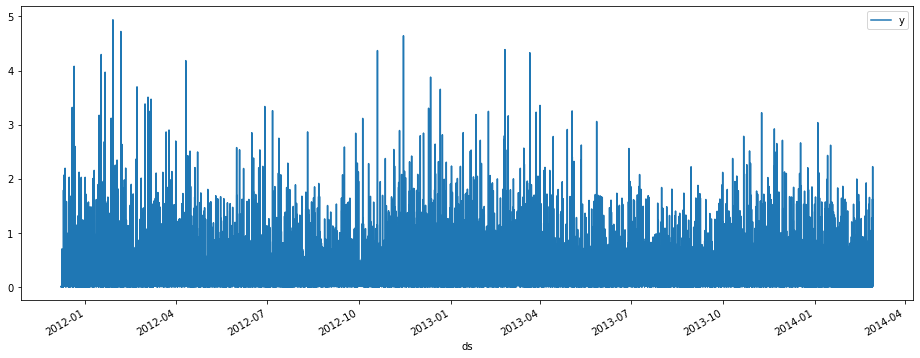

In [27]:
df.plot(x=df.columns[0], y = df.columns[1], figsize=(16,6))

<AxesSubplot:xlabel='ds'>

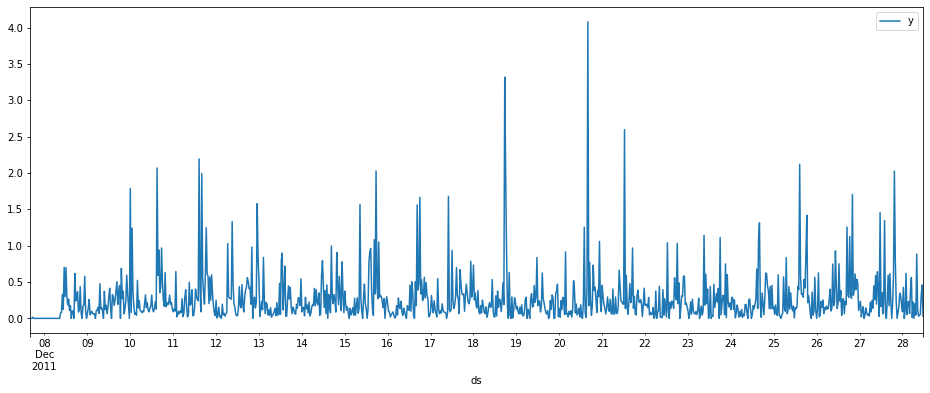

In [28]:
df[:1000].plot(x=df.columns[0], y = df.columns[1], figsize=(16,6))

# Пример использования

In [29]:
pf = ProphetForecaster()
pf.add_train_data(df)
pf.fit([0,3000])
forecast = pf.make_prediction(1000, '30min')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


RMSE:  0.3230957960864084


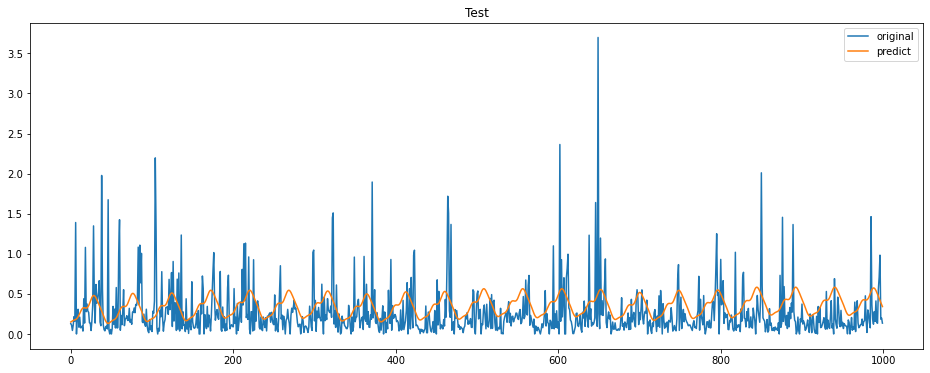

In [30]:
plt.figure(figsize=(16,6))
plt.title("Test")
plt.plot(df['y'][3000:4000].values, label="original")
plt.plot(forecast['yhat'].values, label="predict")
plt.legend()
print("RMSE: ", ((forecast['yhat'] - df['y'][3000:4000].values) ** 2).mean() ** .5)

# Пример с сезонностями

In [31]:
seasonalities = [{'name':'s1', 'period':1, 'fourier_order':39},
                {'name':'s2', 'period':2, 'fourier_order':39}]
pf = ProphetForecaster()
pf.add_seasonalities(seasonalities)
pf.add_train_data(df)
pf.fit([0,3000])
forecast = pf.make_prediction(1000, '30min')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


RMSE:  0.32591204294923426


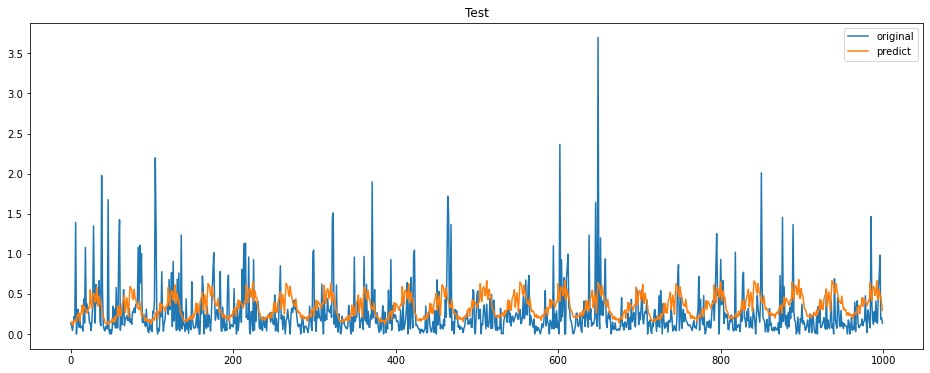

In [32]:
plt.figure(figsize=(16,6))
plt.title("Test")
plt.plot(df['y'][3000:4000].values, label="original")
plt.plot(forecast['yhat'].values, label="predict")
plt.legend()
print("RMSE: ", ((forecast['yhat'] - df['y'][3000:4000].values) ** 2).mean() ** .5)

# Пример с температурным регрессором и сезонностями

In [80]:
temperature_df = pd.read_csv('air_temperature_equatorial_1.csv')
temperature_df = temperature_df.rename(columns={'time': "ds"})
seasonalities = [{'name':'s1', 'period':1, 'fourier_order':39},
                {'name':'s2', 'period':2, 'fourier_order':39}]

In [34]:
pf = ProphetForecaster()
pf.add_seasonalities(seasonalities)
pf.add_train_data(df)
pf.add_regressor(temperature_df, 'temp', '30min')

In [35]:
pf.fit([0,3000])
forecast = pf.make_prediction(1000, '30min')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


RMSE:  0.3279878545833415


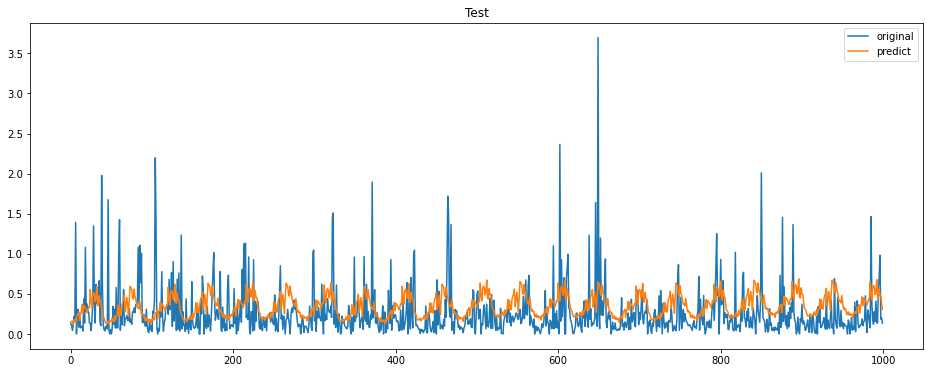

In [36]:
plt.figure(figsize=(16,6))
plt.title("Test")
plt.plot(df['y'][3000:4000].values, label="original")
plt.plot(forecast['yhat'].values, label="predict")
plt.legend()
print("RMSE: ", ((forecast['yhat'] - df['y'][3000:4000].values) ** 2).mean() ** .5)

# Пример с температурным регрессором, сезонностями и переобучением модели

In [37]:
pf.multiple_fit(quantity=5, step=300, train_length=3000, start = 0)
forecast = pf.make_prediction(1000, '30min')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


RMSE:  0.3043119551754458


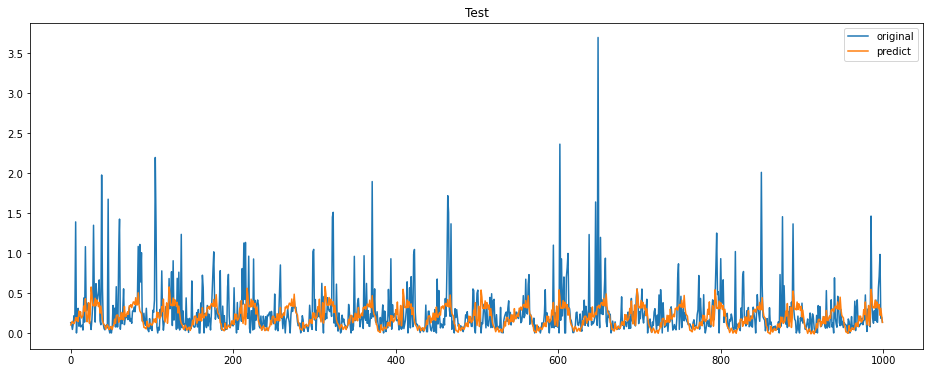

In [38]:
plt.figure(figsize=(16,6))
plt.title("Test")
plt.plot(df['y'][3000:4000].values, label="original")
plt.plot(forecast['yhat'].values, label="predict")
plt.legend()
print("RMSE: ", ((forecast['yhat'] - df['y'][3000:4000].values) ** 2).mean() ** .5)

# Генерация синтетики + шум

In [56]:
def make_noise(train_df, size=0.95):
    X = train_df['y'].values
    Y = np.random.normal(X, size)
    return Y

def mean_confidence_interval(data, confidence=0.96):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return (m-h, m+h)

In [57]:
ndf = df.copy()
ndf['y'] = make_noise(df, 1.5)

In [59]:
predicted_lst = []
for i in range(100):
    print(i)
    ndf = df.copy()
    ndf['y'] = make_noise(df, 1.5)
    pf = ProphetForecaster()
    pf.add_seasonalities(seasonalities)
    pf.add_train_data(df)
    pf.add_regressor(temperature_df, 'temp', '30min')
    pf.multiple_fit(quantity=5, step=300, train_length=3000, start = 0)
    forecast = pf.make_prediction(1000, '30min')
    predicted_lst.append(forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


0


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


KeyboardInterrupt: 

In [83]:
# уже подсчитанные 100 прогнозов
with open('predicted_list_forecaster.pickle', 'rb') as f:
     predicted_lst = pickle.load(f)

In [84]:
# with open('predicted_list_forecaster.pickle', 'wb') as f:
#      pickle.dump(predicted_lst, f)

In [85]:
nlst = []
for i in predicted_lst:
    nlst.append(i['yhat'].values)
predicted_lst = nlst

In [86]:
pred_lst_arr = np.array(predicted_lst)
mean_ts = []
var_ts = []
for i in range(pred_lst_arr.shape[1]):
    mean_ts.append(pred_lst_arr[:,i].mean())
    var_ts.append(pred_lst_arr[:,i].var())
mean_ts = np.array(mean_ts)
var_ts = np.array(var_ts)

mhp_lst = []
mhm_lst = []

for i in range(pred_lst_arr.shape[1]):
    a = pred_lst_arr[:,i]
    interval = mean_confidence_interval(a)
    mhm_lst.append(-1.96*a.var())
    mhp_lst.append(1.96*a.var())

mhp_lst = mean_ts+np.array(mhp_lst)
mhm_lst = mean_ts+np.array(mhm_lst)

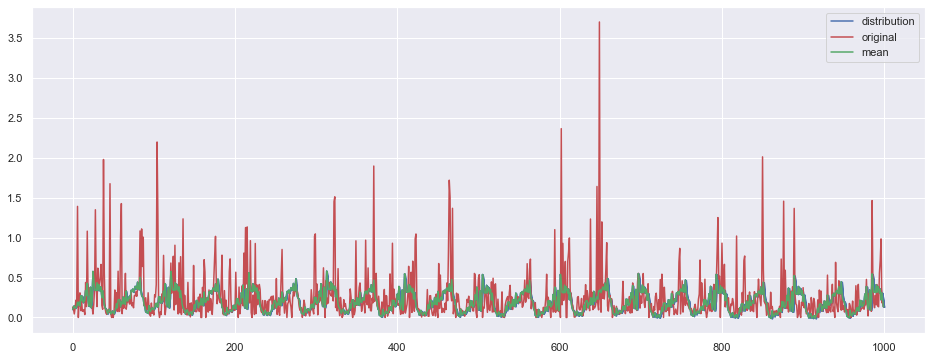

In [87]:
plt.figure(figsize=(16,6))
plt.plot(mhp_lst, color='b', label = 'distribution')
plt.plot(mhm_lst, color='b')
x = np.linspace(0, pred_lst_arr.shape[1], pred_lst_arr.shape[1])
plt.plot(df[3000:4000]['y'].values, color='r', label = 'original')
plt.fill_between(x, mhm_lst, mhp_lst, color='b')
plt.plot(mean_ts, color='g', label = 'mean')
plt.legend()

# Сравнение спектра синтетики и исходного ряда

C:\Users\user\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\user\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


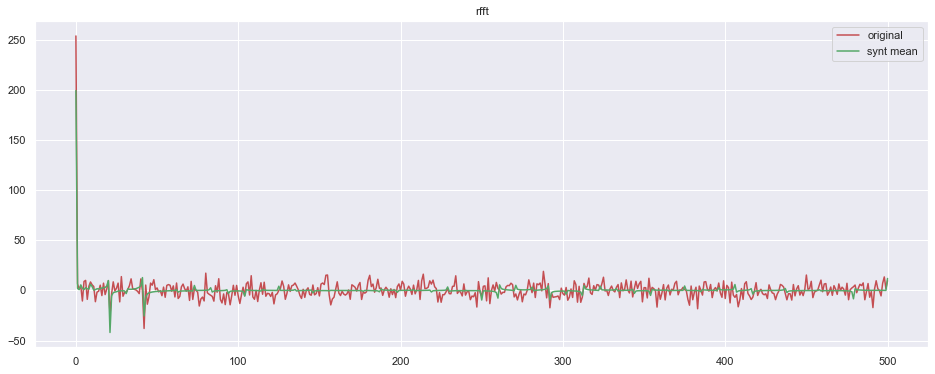

In [82]:
plt.figure(figsize=(16,6))
plt.title("rfft")
rfft_1 = np.fft.rfft(abs(mean_ts))
rfft_2 = np.fft.rfft(abs(df[3000:4000]['y'].values))
plt.plot(rfft_2, label = "original", c='r')
plt.plot(rfft_1, label = "synt mean", c='g')
plt.legend()

 # Сравнение распределений

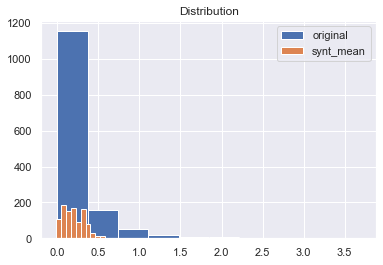

In [66]:
sns.set()
plt.title("Distribution")
plt.hist(df[3000:4400]['y'].values, label = "original")
plt.hist(mean_ts, label = "synt_mean")
plt.legend()

 # Оценка по RMSE, спектру и распределению (длинна входного ряда vs. длина прогноза)

### Длина входного ряда - 2880 (2 месяца), длина прогноза - 17483 (год)

In [67]:
input_len = 2880
forecasting_len = 17483
pf = ProphetForecaster()
pf.add_seasonalities(seasonalities)
pf.add_train_data(df)
pf.add_regressor(temperature_df, 'temp', '30min')
pf.multiple_fit(quantity=5, step=300, train_length=input_len, start = 0)
forecast = pf.make_prediction(forecasting_len, '30min')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


RMSE:  0.6745832366509544


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\user\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


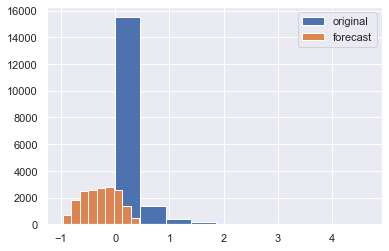

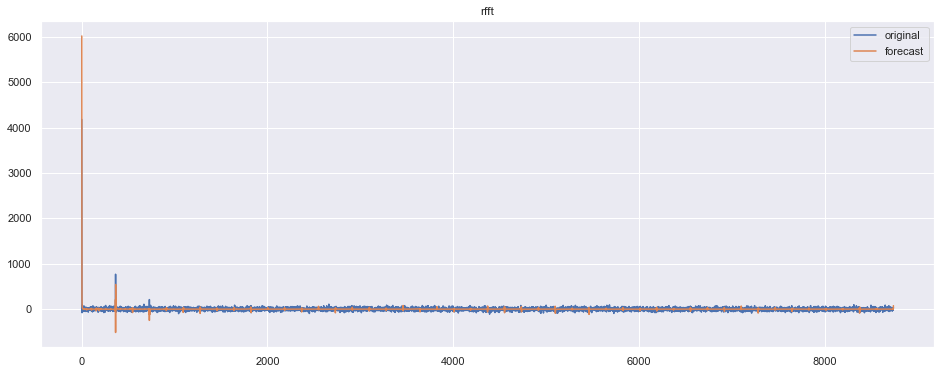

In [69]:
original = df[input_len:input_len + forecasting_len]['y'].values
forecast = forecast['yhat'].values
rfft_1 = np.fft.rfft(abs(original))
rfft_2 = np.fft.rfft(abs(forecast))
print("RMSE: ", ((original - forecast) ** 2).mean() ** .5)
plt.hist(original, label = "original")
plt.hist(forecast, label = "forecast")
plt.legend()

plt.figure(figsize=(16,6))
plt.title("rfft")
plt.plot(rfft_1, label = "original")
plt.plot(rfft_2, label = "forecast")
plt.legend()

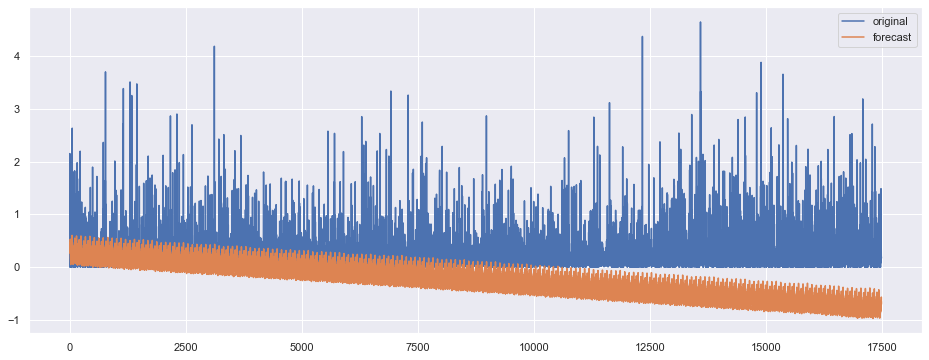

In [70]:
plt.figure(figsize=(16,6))
plt.plot(original, label = "original")
plt.plot(forecast, label = "forecast")
plt.legend()

### Длина входного ряда - 4370 (3 месяца), длина прогноза - 17483 (год)

In [71]:
input_len = 4370
forecasting_len = 17483
pf = ProphetForecaster()
pf.add_seasonalities(seasonalities)
pf.add_train_data(df)
pf.add_regressor(temperature_df, 'temp', '30min')
pf.multiple_fit(quantity=5, step=300, train_length=input_len, start = 0)
forecast = pf.make_prediction(forecasting_len, '30min')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


RMSE:  0.3162607011665235


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\user\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


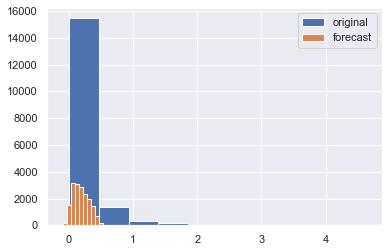

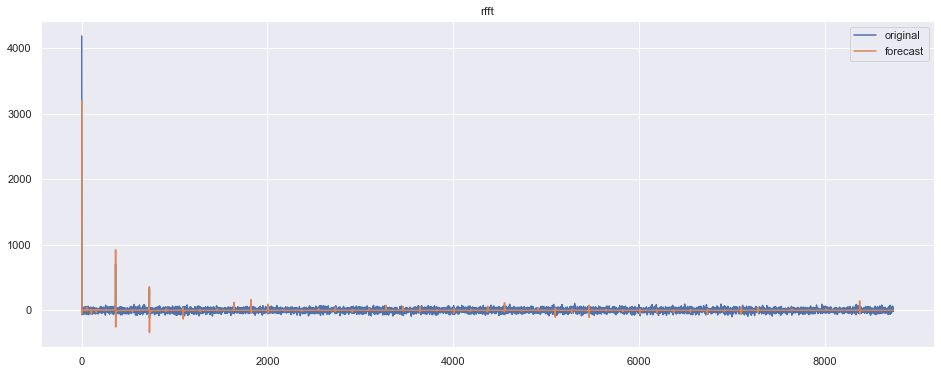

In [72]:
original = df[input_len:input_len + forecasting_len]['y'].values
forecast = forecast['yhat'].values
rfft_1 = np.fft.rfft(abs(original))
rfft_2 = np.fft.rfft(abs(forecast))
print("RMSE: ", ((original - forecast) ** 2).mean() ** .5)
plt.hist(original, label = "original")
plt.hist(forecast, label = "forecast")
plt.legend()

plt.figure(figsize=(16,6))
plt.title("rfft")
plt.plot(rfft_1, label = "original")
plt.plot(rfft_2, label = "forecast")
plt.legend()

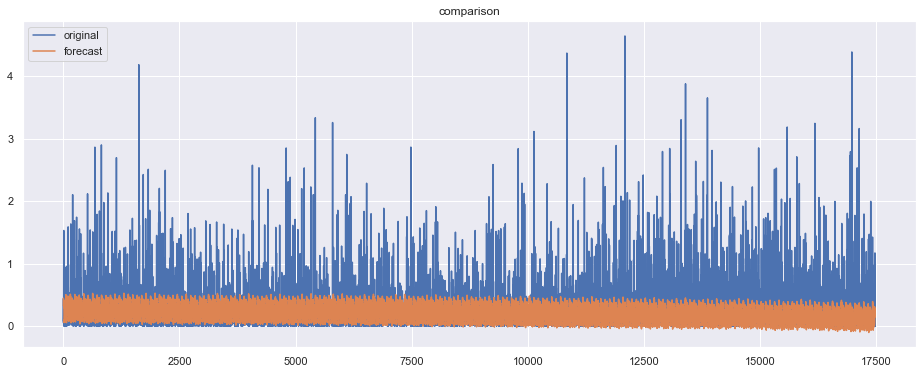

In [73]:
plt.figure(figsize=(16,6))
plt.title("comparison")
plt.plot(original, label = "original")
plt.plot(forecast, label = "forecast")
plt.legend()

### Длина входного ряда - 5907 (4 месяца), длина прогноза - 17483 (год)

In [89]:
input_len = 5907
forecasting_len = 17483
pf = ProphetForecaster()
pf.add_seasonalities(seasonalities)
pf.add_train_data(df)
pf.add_regressor(temperature_df, 'temp', '30min')
pf.multiple_fit(quantity=5, step=300, train_length=input_len, start = 0)
forecast = pf.make_prediction(forecasting_len, '30min')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


RMSE:  0.3357108503498634


C:\Users\user\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\user\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


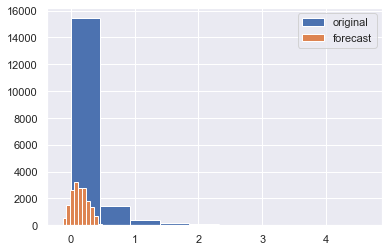

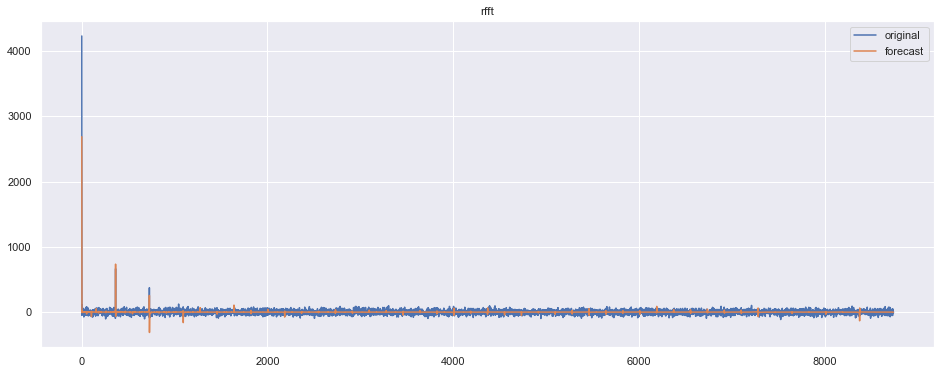

In [90]:
original = df[input_len:input_len + forecasting_len]['y'].values
forecast = forecast['yhat'].values
rfft_1 = np.fft.rfft(abs(original))
rfft_2 = np.fft.rfft(abs(forecast))
print("RMSE: ", ((original - forecast) ** 2).mean() ** .5)
plt.hist(original, label = "original")
plt.hist(forecast, label = "forecast")
plt.legend()

plt.figure(figsize=(16,6))
plt.title("rfft")
plt.plot(rfft_1, label = "original")
plt.plot(rfft_2, label = "forecast")
plt.legend()

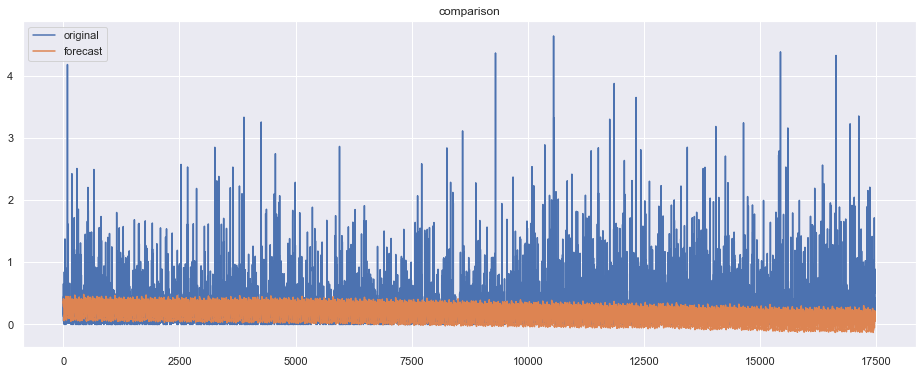

In [91]:
plt.figure(figsize=(16,6))
plt.title("comparison")
plt.plot(original, label = "original")
plt.plot(forecast, label = "forecast")
plt.legend()

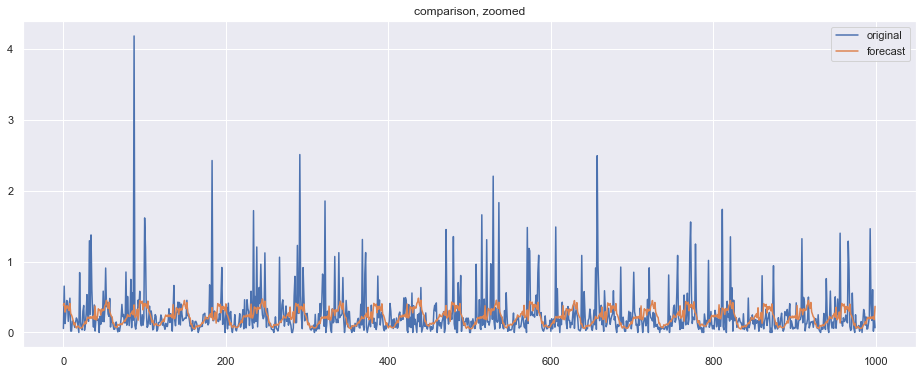

In [93]:
plt.figure(figsize=(16,6))
plt.title("comparison, zoomed")
plt.plot(original[:1000], label = "original")
plt.plot(forecast[:1000], label = "forecast")
plt.legend()